In [1]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import requests
import yfinance as yahooFinance
import pandas as pd

In [2]:
%%capture
%run -i -e Pair_Selection_rework.ipynb

## Defining Parameters
There are plenty of parameters that can be adjusted in order to align the strategy with users chosen risk management. They can be set up here and alternate the buying heuristics
  
Z-Scores

In [6]:
# Time frames (trading days) to consider while defining the z-score
time_for_average = 60      # (Rolling) days to consider for the average
time_for_x = 5         # (Rolling) days to consider for x

# Z-scores where the trades are introduced
# Note: this value is considered in both directions 
# ( e.g. the trades for start_z = 1 are made at 1 and minus 1)
start_z = 1

# Z-scores where the trades are closed
# Note: the sign is considered relative to the upper z  
# ( e.g. start_z = 1  and end_z = -1: a trade is started at one and closed at -1, the inverse starts at -1 and closes at 1 )
end_z = -1


Risk Management

In [18]:
# Maximum numbers of active trades within one pair
quantity_limit = 80

# Maximum numbers of trading days that a pair can be hold
time_limit = 120

# Z-Score, where the trades are stopped in order to cut losses
z_limit = 5 

Order fees

In [8]:
# Trade volume: Money that is spent per signal
# (e.g. long stock 1 with trade volume and short stock 2 with trade volume )
trade_volume = 500

# Order fees per transaction
# Assume Trade Republic fees of one euro
orderfeeabs = 1

# Traxes on capital gains
# Assume German tax rates
taxes = 0.26375

## Data Sourcing
To able to evaluate the stocks performances till the current day, we need to get the evolution of stock prices from the end of our training time frame till today. In order to access these informations, we source the data of our chosen stocks from yahoo finance. The adjusted close is in this case the correct stock price for each daay, since the avavlable training data corresponds to it as well

In [4]:

unique_pair = []
for pair in selected_pairs:
    if pair[0] not in unique_pair:
        unique_pair.append(pair[0])
    if pair[1] not in unique_pair:
        unique_pair.append(pair[1])
stock_df_top_pairs = pd.DataFrame(yahooFinance.download(unique_pair, start="2022-01-02",end="2023-12-31")["Adj Close"])

[*********************100%%**********************]  31 of 31 completed


## Generation of tickers
We now investigate on the test data. First of all, we determine the z-score with the rolling average of 5 days for the current price and the rolling average of 60 days for the longtime. This enables us to evaluate the score with rather relevant than historic data. We then define our buy and sell signals and visualize them in a plot.

$ Z = \dfrac{x_{5 Days}-\bar x_{60 Days}}{\sigma _{60 Days}}$

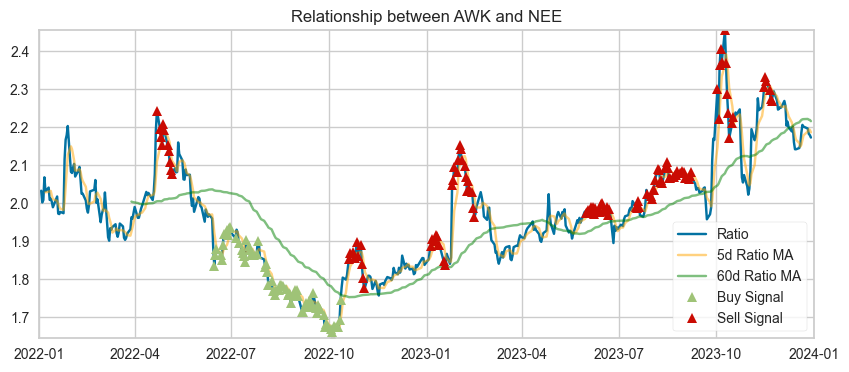

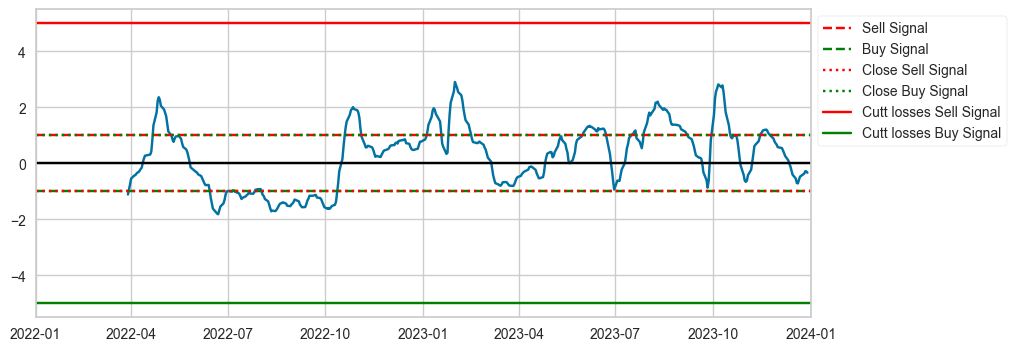

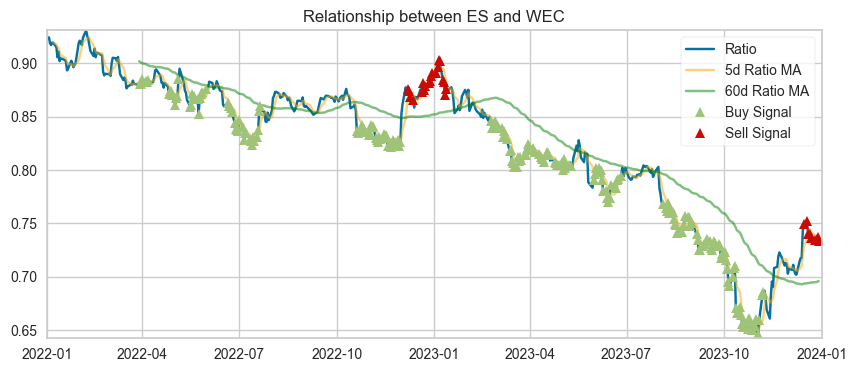

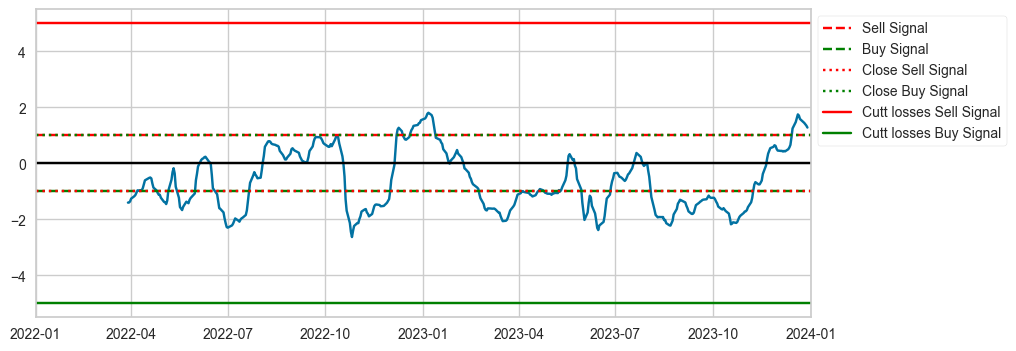

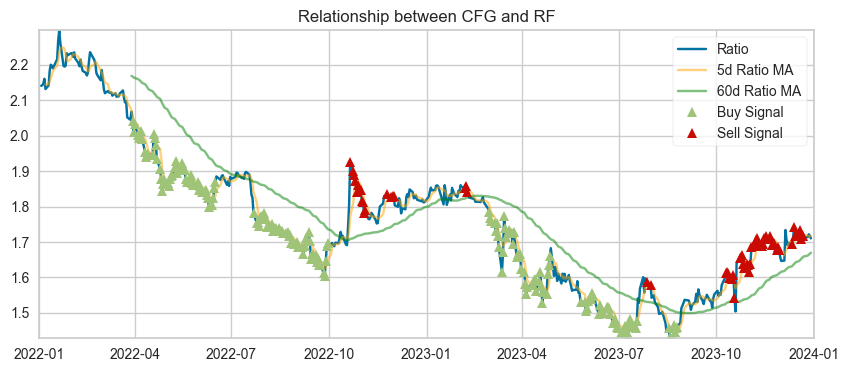

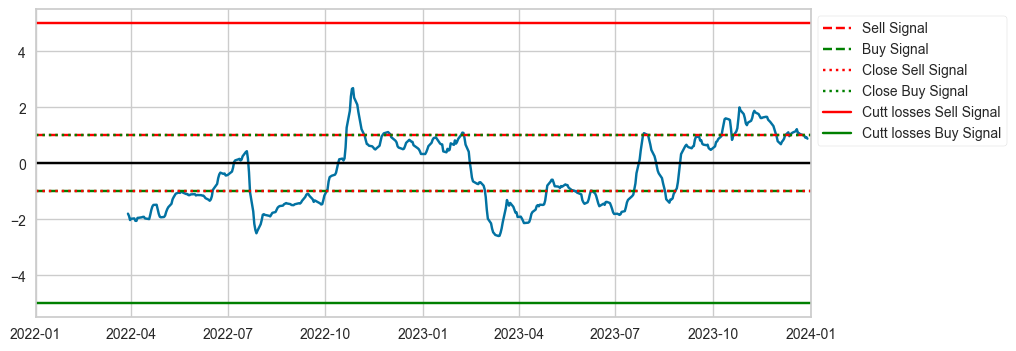

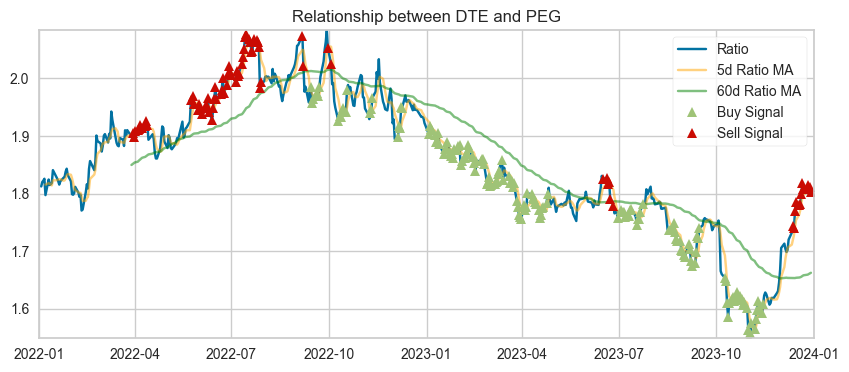

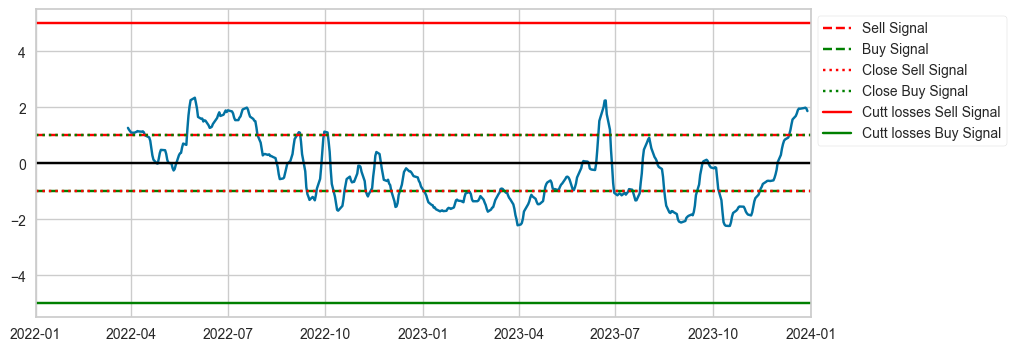

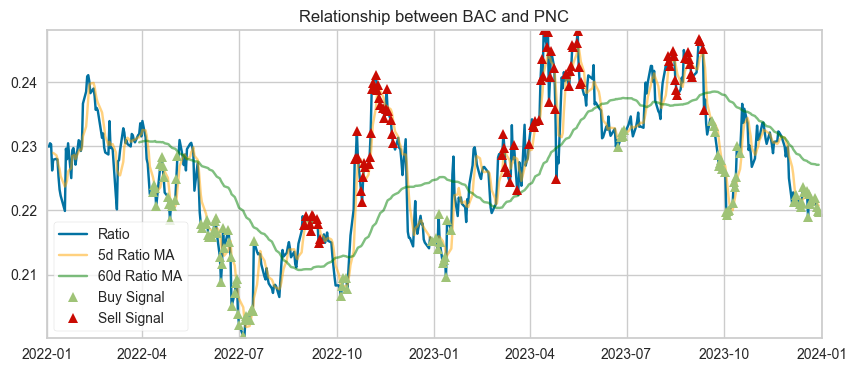

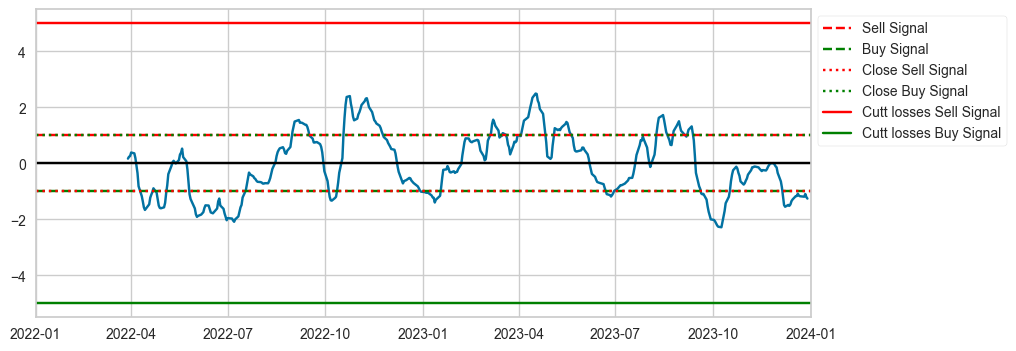

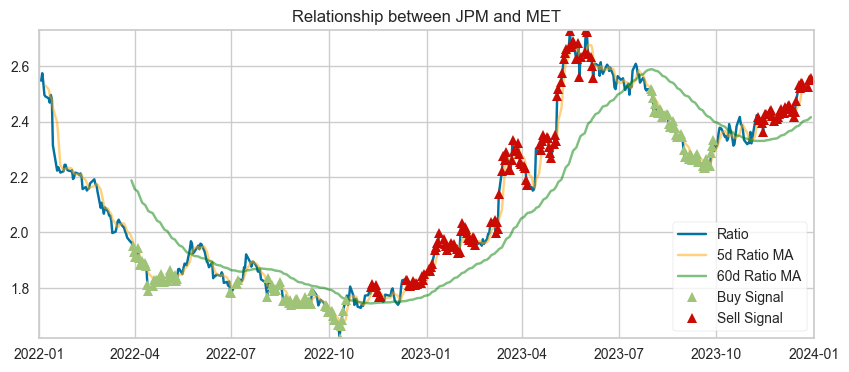

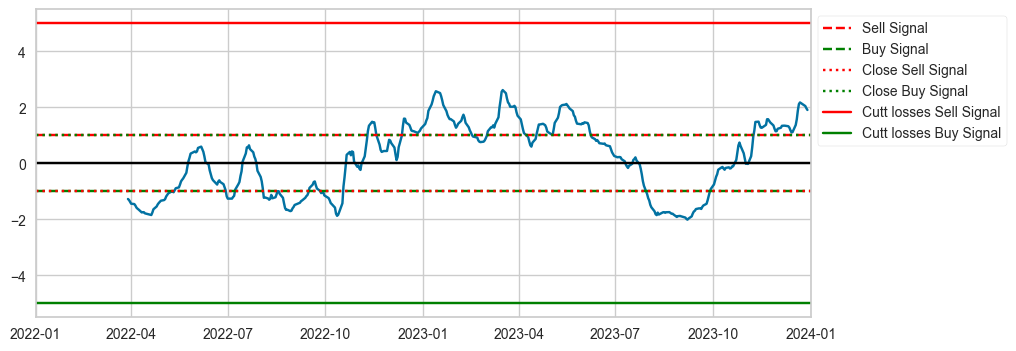

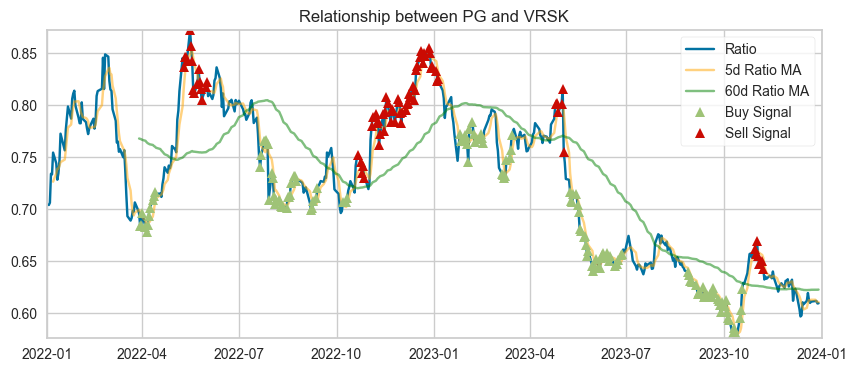

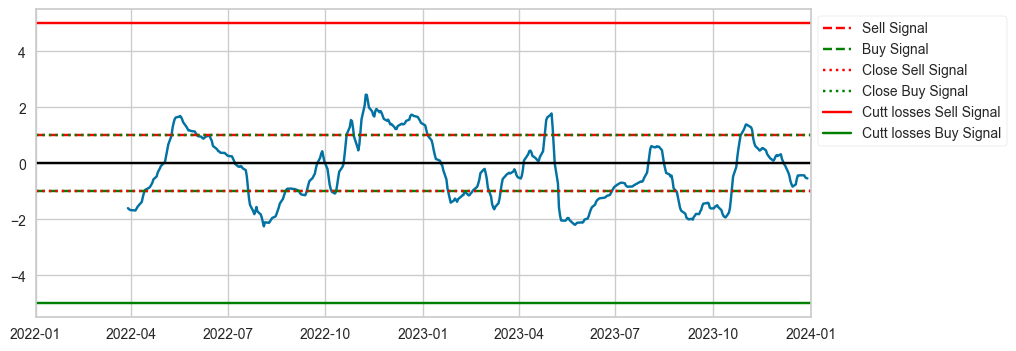

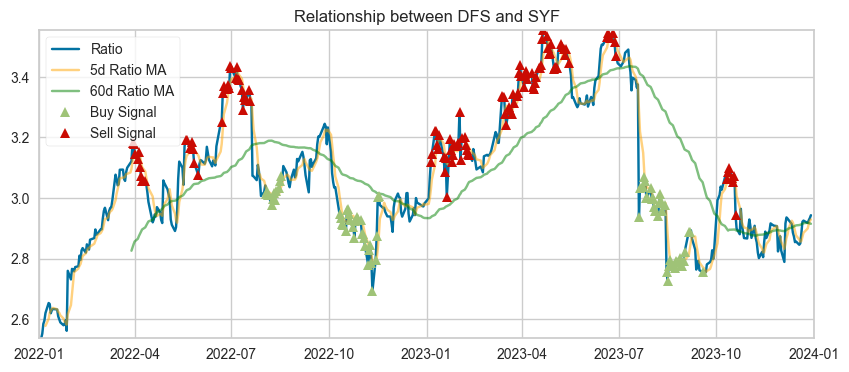

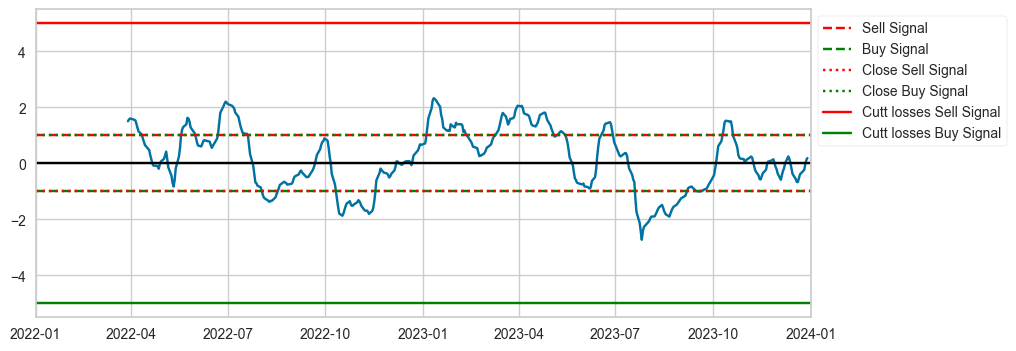

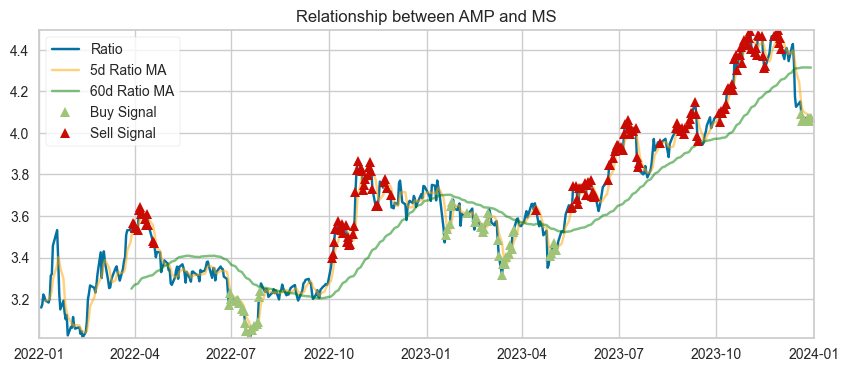

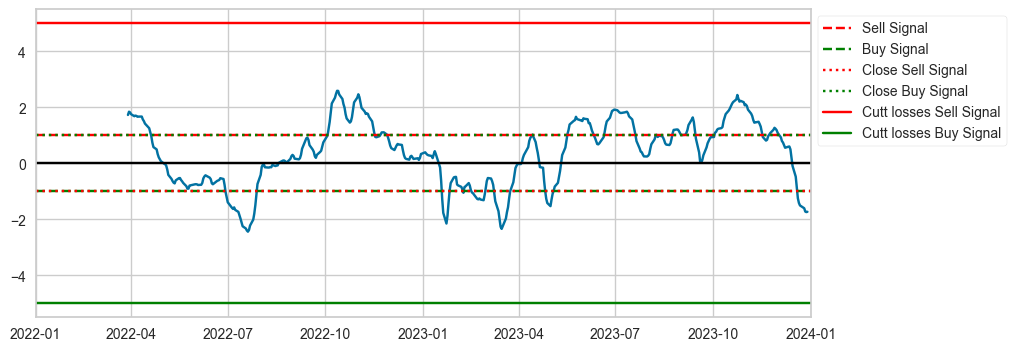

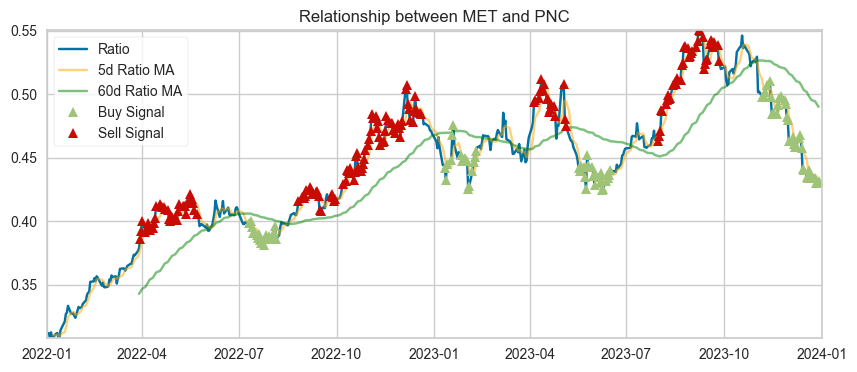

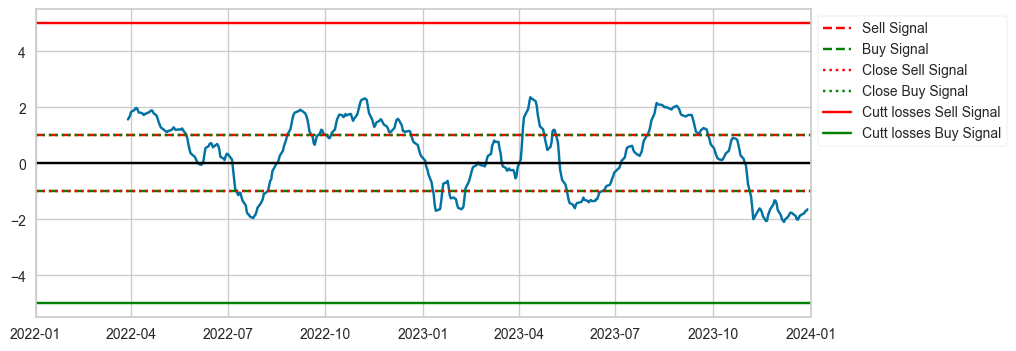

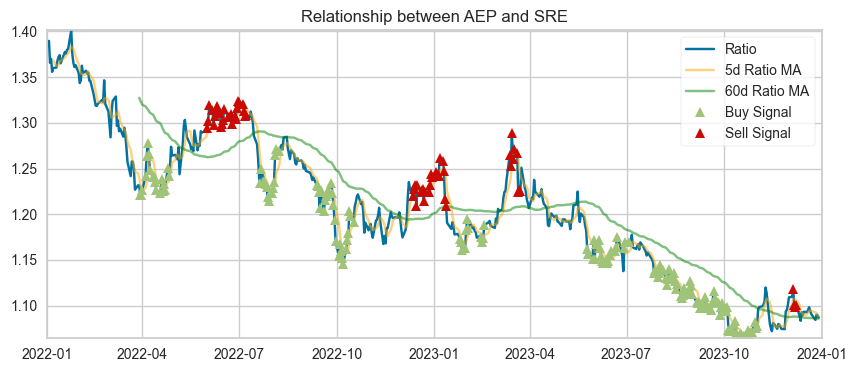

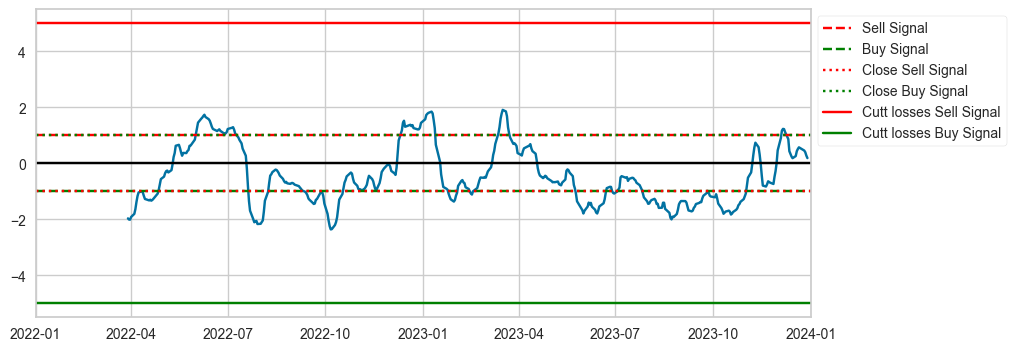

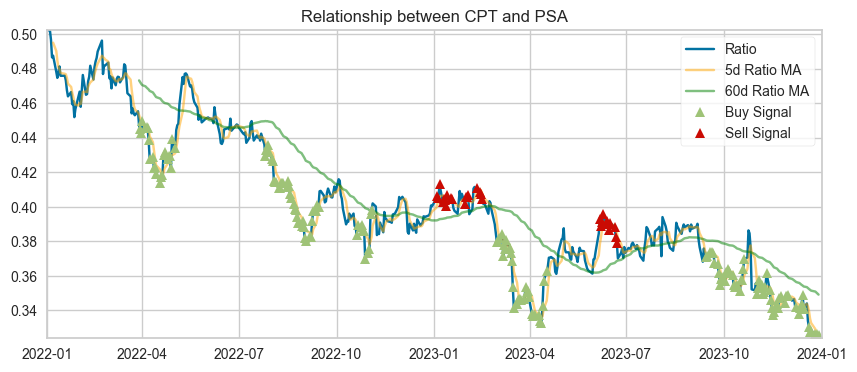

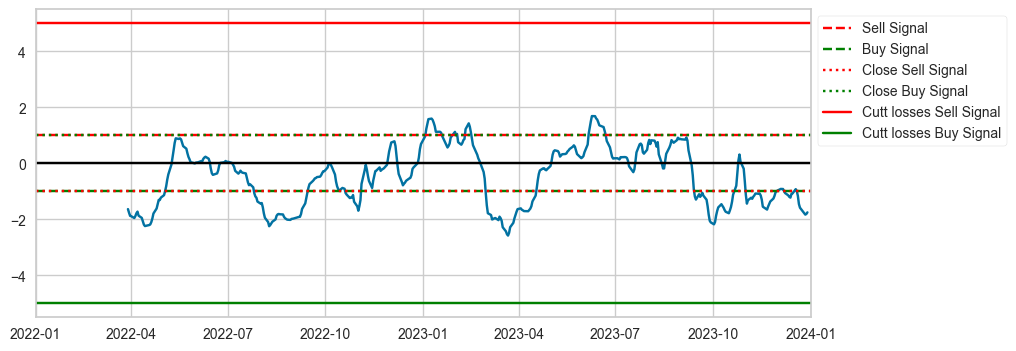

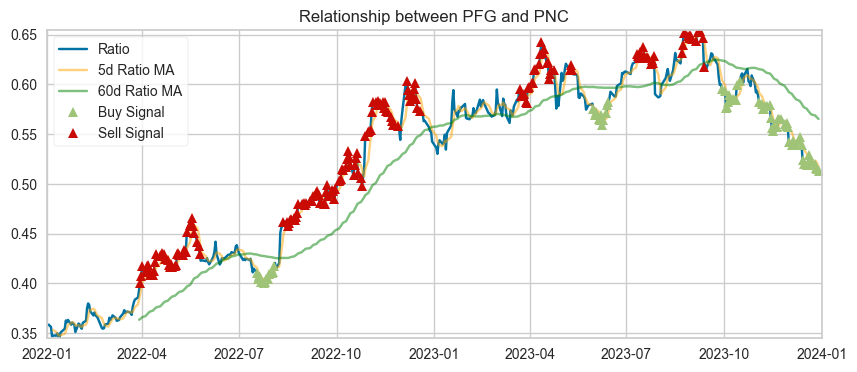

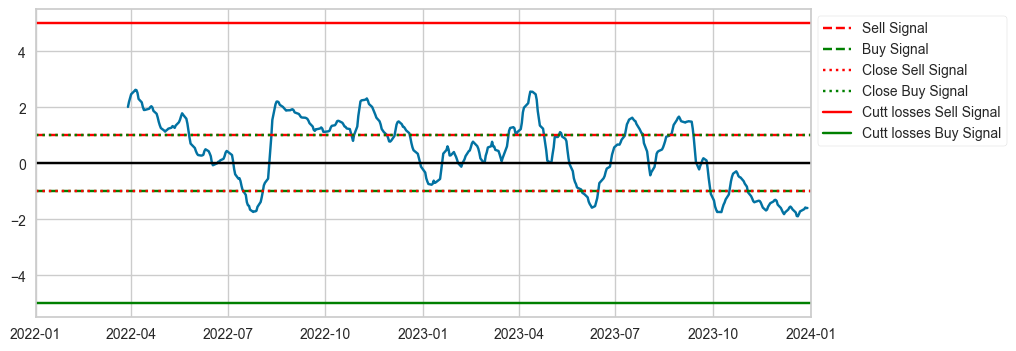

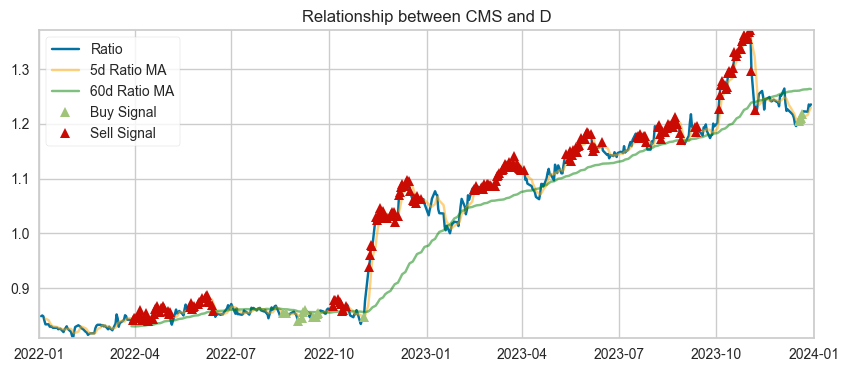

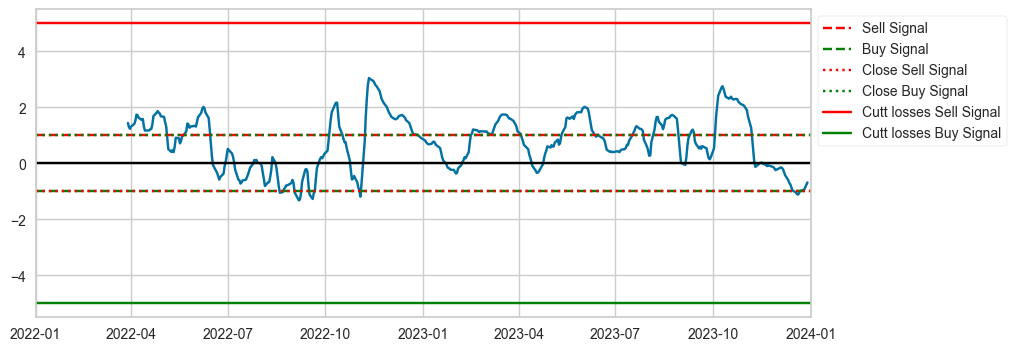

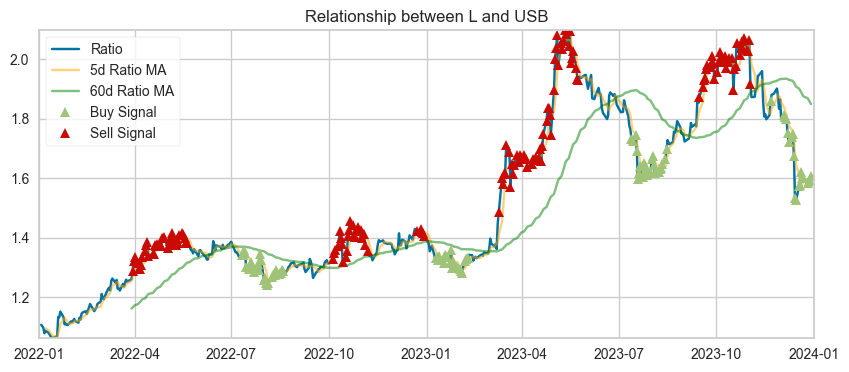

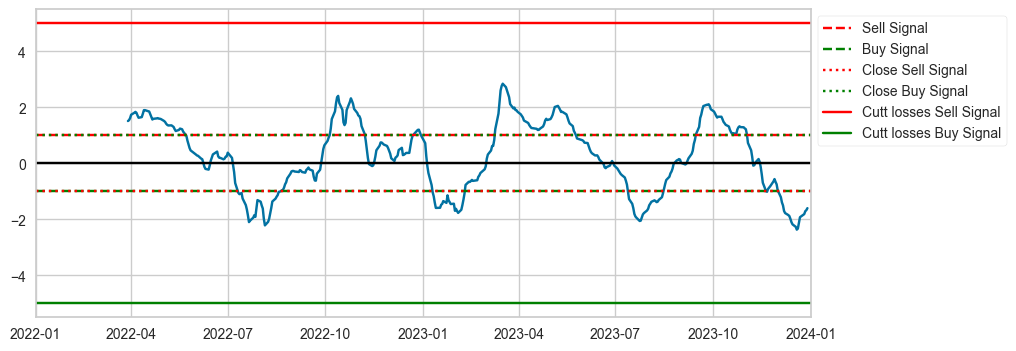

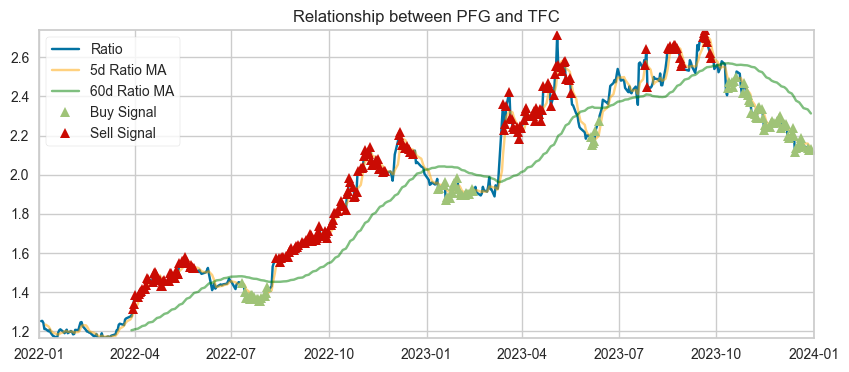

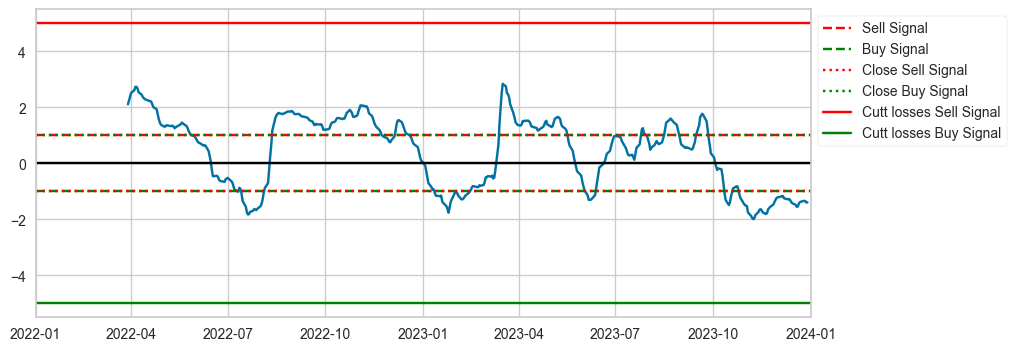

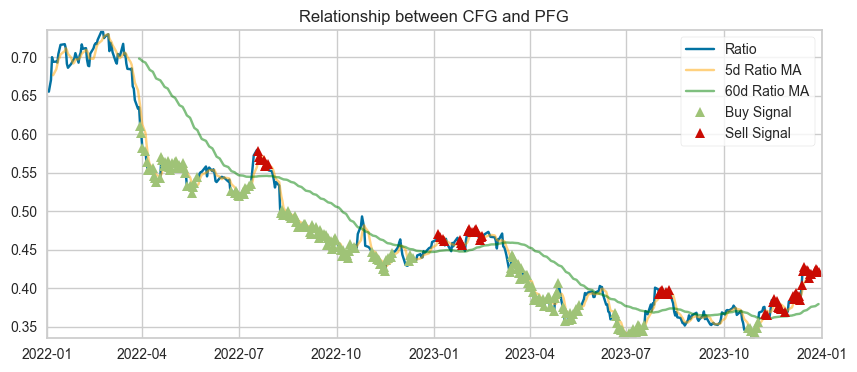

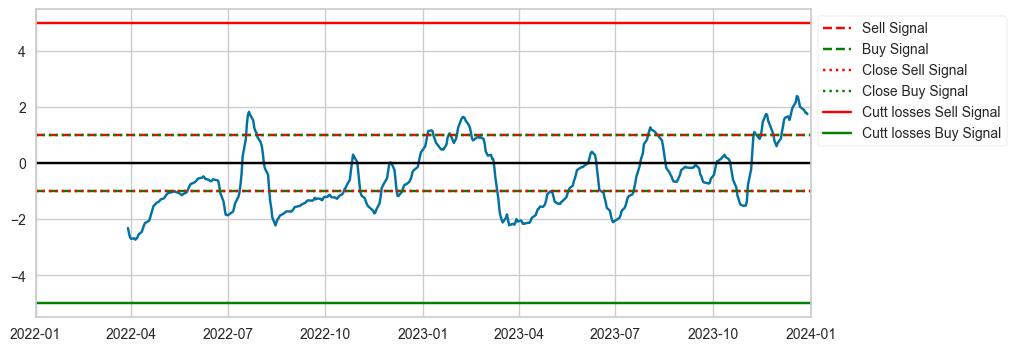

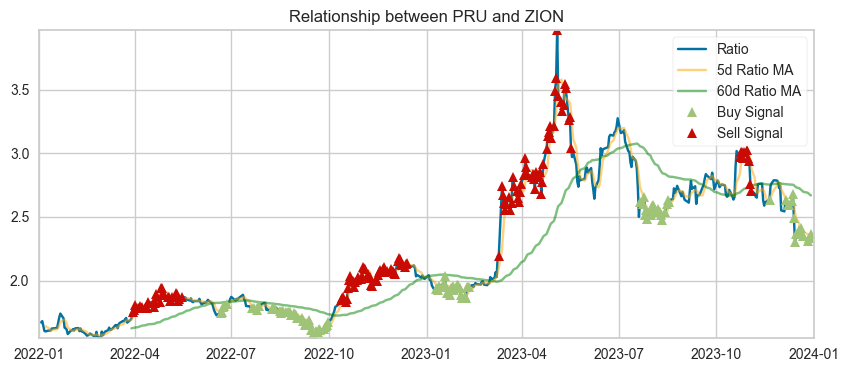

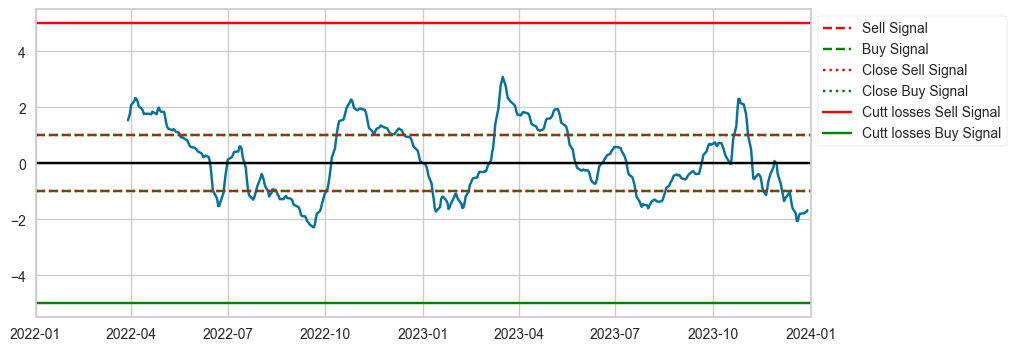

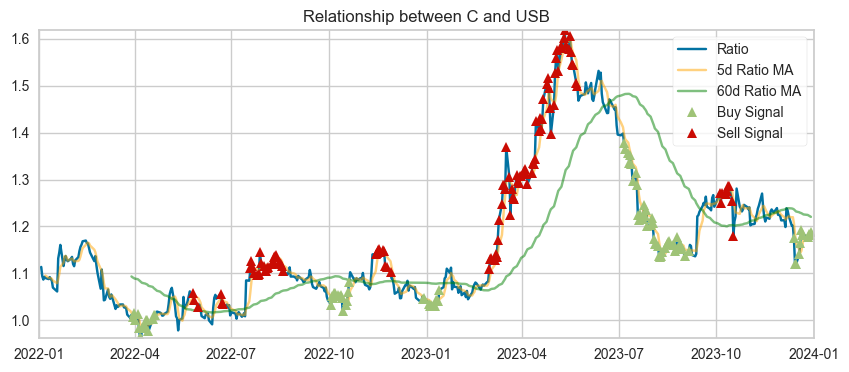

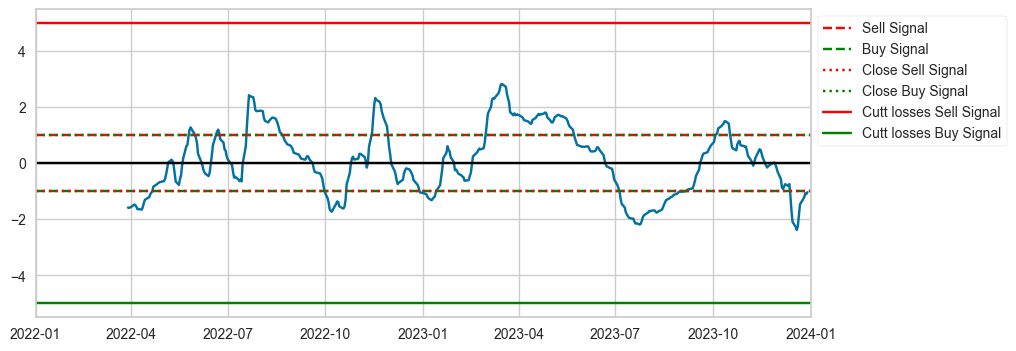

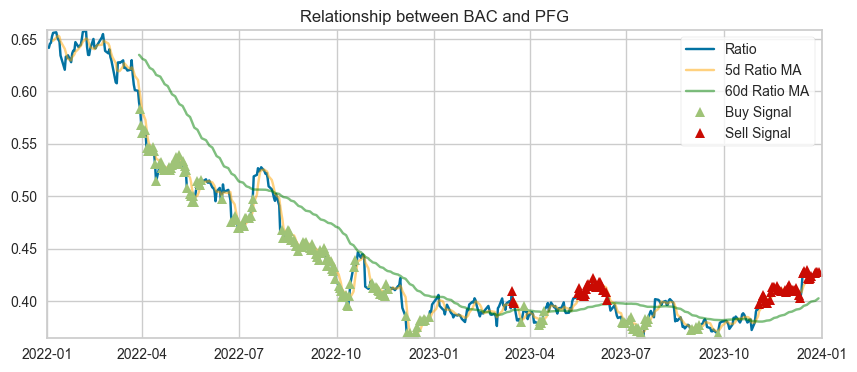

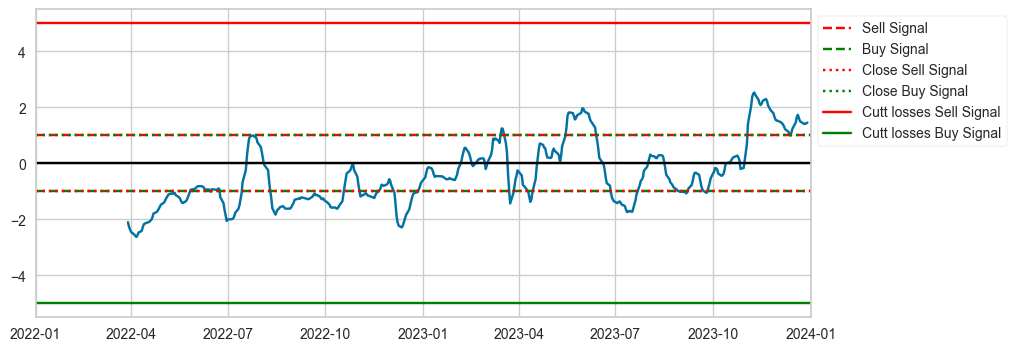

In [9]:
for pair in selected_pairs:

    stock_1 = stock_df_top_pairs[pair[0]]
    stock_2 = stock_df_top_pairs[pair[1]]

    # Define ratio of the pair
    ratio = stock_1 / stock_2

    # Determine rolling averages of 5 and 60 days
    ratio_mavg_5 = ratio.rolling(window= 5, center=False).mean()
    ratio_mavg_60 = ratio.rolling(window= 60, center=False).mean()

    # Determine Z-score
    ratio_z = ratio.rolling(window= time_for_x, center=False).mean()
    ratio_mavg_z = ratio.rolling(window= time_for_average, center=False).mean()
    std_z = ratio.rolling(window=time_for_average, center=False).std()
    zscore = (ratio_z - ratio_mavg_z)/std_z

    # Create signals, where stock_1 is bought and sold (and stock_2 vice versa) 
    buy = ratio.copy()
    sell = ratio.copy()
    buy[:time_for_average]= np.nan
    sell[:time_for_average]= np.nan
    buy[zscore>-1] = np.nan
    sell[zscore<1] = np.nan


    # Plot ratio with signals
    plt.figure(figsize=(10, 4))
    plt.plot(ratio,  label="Ratio")
    plt.plot(ratio_mavg_5, c = 'orange', alpha = 0.5,  label="5d Ratio MA")
    plt.plot(ratio_mavg_60, c = 'green', alpha = 0.5,  label="60d Ratio MA")
    plt.plot(buy, color='g', linestyle='None', marker='^',  label="Buy Signal")
    plt.plot(sell, color='r', linestyle='None', marker='^',  label="Sell Signal")
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, ratio.min(), ratio.max()))
    plt.legend(frameon=True, facecolor='white')
    plt.title(f'Relationship between {pair[0]} and {pair[1]}')
    plt.xlim(datetime(2022,1,1),datetime(2024,1,1))
    plt.show()

    # Plot Z-Score with relevant frontiers
    plt.figure(figsize=(10, 4))
    plt.plot(zscore)
    plt.axhline(0, color='black')
    plt.axhline(start_z, color='red', linestyle='--', label = "Sell Signal")
    plt.axhline(-start_z, color='green', linestyle='--', label= "Buy Signal")
    plt.axhline(end_z, color='red', linestyle='dotted', label="Close Sell Signal")
    plt.axhline(-end_z, color='green', linestyle='dotted', label="Close Buy Signal")
    plt.axhline(z_limit, color='red', linestyle='solid', label= "Cutt losses Sell Signal")
    plt.axhline(-z_limit, color='green', linestyle='solid', label= "Cutt losses Buy Signal")
    plt.xlim(datetime(2022,1,1),datetime(2024,1,1))
    plt.legend(frameon=True, facecolor='white',loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [29]:
# Trading strategy
trade_list = pd.DataFrame(columns=['StartDate','LongStock','LongStartPrice','ShortStock','ShortStartPrice','ClosingDate','LongClosingPrice','ShortClosingPrice','ClosingCount','Status'])
number_of_trading_days = len(zscore) - 1
test= ""
for pair in selected_pairs:
    stock_1 = stock_df_top_pairs[pair[0]]
    stock_2 = stock_df_top_pairs[pair[1]]
    ratio = stock_1 / stock_2

    # Determine Z-score
    ratio_z = ratio.rolling(window=time_for_x, center=False).mean()
    ratio_mavg_z = ratio.rolling(window=time_for_average, center=False).mean()
    std_z = ratio.rolling(window=time_for_average, center=False).std()
    zscore = (ratio_z - ratio_mavg_z)/std_z

    for day, zscore_value in enumerate(zscore):
        # Check strategy of long stock 1 and short stock 2 
        if zscore_value < -start_z : # Open trade
            if len(trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open')]) < quantity_limit:
                new_row = pd.DataFrame({'StartDate':[day],'LongStock':[pair[0]],'LongStartPrice':[stock_1.iloc[day]],'ShortStock':[pair[1]],
                                        'ShortStartPrice':[stock_2.iloc[day]],'Status':['open'],'ClosingDate':['open'],'LongClosingPrice':['open'],'ShortClosingPrice':['open'],'ClosingCount':[0]})
                trade_list = pd.concat([trade_list, new_row], ignore_index=True)
        # Check z-score to see if the trades need to be closed

        if zscore_value > -end_z: # close trades
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_1.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_2.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'Status'] = 'Normally closed'
       
        if zscore_value < -z_limit: # Risk Management: close trades, because z-score is to big and correlation doesnt seem to exist anymore -> risk management
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_1.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_2.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed due to z limit'
            print("risk mgmt, buy, z-score is to big, the pair", pair[0], "&", pair[1], "will be removed. The Z-score exceed risk limitations")
            break

        # Risk Management : Close trades that are older than the maximal accepted period
        trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'ClosingDate']= day
        trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'LongClosingPrice']= stock_1.iloc[day]
        trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'ShortClosingPrice']= stock_2.iloc[day]
        trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'Status'] = 'closed due to time limit'
        
        # Stop trading that pair in case of risk management application
        if not trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'closed due to time limit')].empty:
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_1.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_2.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed due to time limit'
            print("Risk Management: ", pair[0], "&", pair[1], "will be removed from the trading plan. The max holding period was exceeded.")
            break

        # Check strategy of long stock 1 and short stock 2 
        if zscore_value > start_z : # Open trade
            if len(trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open')]) < quantity_limit:
                new_row = pd.DataFrame({'StartDate':[day],'LongStock':[pair[1]],'LongStartPrice':[stock_2.iloc[day]],'ShortStock':[pair[0]],
                                        'ShortStartPrice':[stock_1.iloc[day]],'Status':['open'],'ClosingDate':['open'],'LongClosingPrice':['open'],'ShortClosingPrice':['open'],'ClosingCount':[0]})
                trade_list = pd.concat([trade_list, new_row], ignore_index=True)
        # Check z-score to see if the trades need to be closed
        if zscore_value < end_z: # close trades
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_2.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_1.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'Status'] = 'Normally closed'
       
        if zscore_value > z_limit: # Risk Management: close trades, because z-score is to big and correlation doesnt seem to exist anymore -> risk management
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_2.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_1.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed due to z limit'
            print("risk mgmt, buy, z-score is to big, the pair", pair[0], "&", pair[1], "will be removed. The Z-score exceed risk limitations")
            break

        # Risk Management : Close trades that are older than the maximal accepted period
        trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'ClosingDate']= day
        trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'LongClosingPrice']= stock_2.iloc[day]
        trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'ShortClosingPrice']= stock_1.iloc[day]
        trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open')& (trade_list['StartDate'] <= day -time_limit), 'Status'] = 'closed due to time limit'

        # Stop trading that pair in case of risk management application
        if not trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'closed due to time limit')].empty:
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ClosingDate']= day
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'LongClosingPrice']= stock_2.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'ShortClosingPrice']= stock_1.iloc[day]
            trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['Status'] == 'open'), 'Status'] = 'closed due to time limit'
            print("Risk Management: ", pair[1], "&", pair[0], "will be removed from the trading plan. The max holding period was exceeded.")
            break
print(f"Simulation completed.\nA total of {len(trade_list)} trades have been made.")

Risk Management:  NEE & AWK will be removed from the trading plan. The max holding period was exceeded.
Risk Management:  ES & WEC will be removed from the trading plan. The max holding period was exceeded.
Risk Management:  CFG & RF will be removed from the trading plan. The max holding period was exceeded.
Risk Management:  DTE & PEG will be removed from the trading plan. The max holding period was exceeded.
Risk Management:  JPM & MET will be removed from the trading plan. The max holding period was exceeded.
Risk Management:  SYF & DFS will be removed from the trading plan. The max holding period was exceeded.
Risk Management:  MS & AMP will be removed from the trading plan. The max holding period was exceeded.
Risk Management:  AEP & SRE will be removed from the trading plan. The max holding period was exceeded.
Risk Management:  CPT & PSA will be removed from the trading plan. The max holding period was exceeded.
Risk Management:  PNC & PFG will be removed from the trading plan. 

## Preparation of Results

In [30]:
# Filter trades that have now been closed in the undergone time frame
# Assuming continuity of the strategy, therefore we can hold on to them in the future and they have not to be closed
open_trades = trade_list[trade_list['Status']=='open']
trade_list = trade_list[trade_list['Status']!='open']
trade_list.reset_index(inplace=True,drop=True)

# Add Information of how many trades were closed at the same time
for pair in selected_pairs:
    for day, zscore_value in enumerate(zscore):
        trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['ClosingDate'] == day), 'ClosingCount']=trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]) & (trade_list['ClosingDate'] == day)].shape[0]
        trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['ClosingDate'] == day), 'ClosingCount']=trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1]) & (trade_list['ClosingDate'] == day)].shape[0]

## Application of investments
Determination of profits with the given trading strategy

In [31]:
# Gross Profit: Profit generated by multiplying the stock price differences by the chosen trade volume
trade_list['GrossProfit'] = (trade_volume/trade_list['LongStartPrice'])*(trade_list['LongClosingPrice']-trade_list['LongStartPrice'])+ (trade_volume/trade_list['ShortStartPrice'])*(trade_list['ShortStartPrice']-trade_list['ShortClosingPrice'])

# Net Profit: Deduction of order fees and taxes on gross profits
# Note: Order fees are applied for the start call and once for the closing call (where all positions are sold together)
trade_list['NetProfit'] = (trade_list['GrossProfit']  - (2+2/trade_list['ClosingCount'])*orderfeeabs)*(1-taxes)
trade_list = trade_list.drop("ClosingCount", axis = 1)
# Return Rate: the return is calculated relative to the trade volume times 2, since the volume is applied on the long and the short
trade_list['ReturnRate'] = trade_list['NetProfit']/trade_volume/2

# Return Rate p.a.: The Return Rate is scaled on a yearly return
trade_list['ReturnRatePA'] = trade_list['ReturnRate']*252/(trade_list['ClosingDate']-trade_list['StartDate'])

trade_list.head(30)

,StartDate,LongStock,LongStartPrice,ShortStock,ShortStartPrice,ClosingDate,LongClosingPrice,ShortClosingPrice,Status,GrossProfit,NetProfit,ReturnRate,ReturnRatePA
0,59,AWK,159.091553,NEE,81.023781,76,158.85939,70.807228,Normally closed,62.31698,42.935876,0.042936,0.636461
1,76,NEE,70.807228,AWK,158.859390,113,71.44165,131.205215,Normally closed,91.519713,65.775025,0.065775,0.447981
2,77,NEE,70.893410,AWK,155.579651,113,71.44165,131.205215,Normally closed,82.20092,58.914064,0.058914,0.412398
3,78,NEE,70.443398,AWK,153.112579,113,71.44165,131.205215,Normally closed,78.625549,56.281697,0.056282,0.405228
4,79,NEE,70.156128,AWK,151.158295,113,71.44165,131.205215,Normally closed,75.162478,53.732011,0.053732,0.398249
5,80,NEE,70.366783,AWK,155.453857,113,71.44165,131.205215,Normally closed,85.630657,61.439208,0.061439,0.469172
6,81,NEE,68.001762,AWK,149.068527,113,71.44165,131.205215,Normally closed,85.209081,61.128823,0.061129,0.481389
7,82,NEE,66.900635,AWK,143.989304,113,71.44165,131.205215,Normally closed,78.331002,56.064836,0.056065,0.455753
8,83,NEE,67.752808,AWK,144.753601,113,71.44165,131.205215,Normally closed,74.020899,52.891523,0.052892,0.444289
9,84,NEE,69.955070,AWK,147.539932,113,71.44165,131.205215,Normally closed,65.982182,46.973018,0.046973,0.408179


In [32]:
# We can now identify the gains and losses for every pair
returns_per_pair = []

# We consider both directions for each pair
for pair in selected_pairs:
    pair_trades = pd.concat([trade_list.loc[(trade_list['LongStock'] == pair[1]) & (trade_list['ShortStock'] == pair[0]),], trade_list.loc[(trade_list['LongStock'] == pair[0]) & (trade_list['ShortStock'] == pair[1])]], ignore_index=True)
    gross_profit = sum(pair_trades["GrossProfit"])
    net_profit = sum(pair_trades["NetProfit"])
    number_trades = len(pair_trades)
    avg_holding_time = (pair_trades["ClosingDate"]-pair_trades["StartDate"]).mean()
    if avg_holding_time is np.nan:
        avg_holding_time =0
    returns_per_pair.append((pair[0],pair[1],number_trades,avg_holding_time,gross_profit,net_profit))

#Create DataFrame
returns_per_pair = pd.DataFrame(returns_per_pair,columns= ["Stock1","Stock2","NumberOfTrades","AvgHoldingTime","GrossProfit", "NetProfit"])

returns_per_pair

,Stock1,Stock2,NumberOfTrades,AvgHoldingTime,GrossProfit,NetProfit
0,AWK,NEE,124,51.701613,2369.654059,1556.177801
1,ES,WEC,48,76.166667,311.235392,156.994558
2,CFG,RF,80,73.600000,-4826.819645,-3673.018464
3,DTE,PEG,144,50.972222,-1682.463481,-1456.643738
4,BAC,PNC,163,42.828221,3262.648045,2150.327123
5,JPM,MET,64,62.578125,-888.399276,-749.796467
6,PG,VRSK,210,47.061905,5756.842493,3918.942785
7,DFS,SYF,153,59.816993,1109.865774,587.428676
8,AMP,MS,184,52.902174,-501.180316,-650.241507
9,MET,PNC,228,44.842105,4993.576216,3330.482989


In [33]:
# Finally, the total gains are determined 
total_gross_profit = sum(trade_list['GrossProfit'])
total_net_profit = sum(trade_list['NetProfit'])
total_rate_pa = trade_list['ReturnRatePA'].mean()
total_rate = trade_list['ReturnRate'].mean()
avg_holding_time = (trade_list['ClosingDate']-trade_list['StartDate']).mean()

#Create DataFrame
total_KPIs = pd.DataFrame({"NumberOfTrades": [len(trade_list)],"AvgHoldingTime":avg_holding_time,"GrossProfit":[total_gross_profit],"NetProfit":[total_net_profit],"AvgReturnRate":[total_rate],"AvgReturnRatePA":[total_rate_pa]})

total_KPIs

,NumberOfTrades,AvgHoldingTime,GrossProfit,NetProfit,AvgReturnRate,AvgReturnRatePA
0,3117,51.441771,32737.803788,19372.065539,0.006215,-inf


In [22]:
#Export results to Excelmdr
with pd.ExcelWriter("Trading_results.xlsx", engine='xlsxwriter') as writer:
    trade_list.to_excel(writer, sheet_name='TradeList', index=False)
    returns_per_pair.to_excel(writer, sheet_name='PairList', index=False)
    total_KPIs.to_excel(writer, sheet_name='Total', index=False)